In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('science')

matplotlib.rc('text', usetex = True)

def binom(n,k):
    if n < 0:
        return 0
    if n >= k:
        return int(scipy.special.binom(n,k))
    else:
        return 0

# Pr(alpha(theta,k)) run probability

We define profile_vec as the vector which is Pr(alpha(theta,k)) in the paper given a mutation rate $\theta$. The formula is given in the paper.
    
    


In [2]:
def profile(a_p1,theta,k,count = False):
    if a_p1 == k:
        return (1 - theta)**(2*k-1)

    a = a_p1 - 1
    profile_prob = 0

    for b in range(0,k-a-1):
        Tk = 2*binom(k-2-a,b) + (k-a-2)*binom(k-3-a,b)
        profile_prob += Tk * (1-theta)**(k+a+b)*(theta)**(k-a-b-1)
    if count:
        #if theta = 1/2, this returns a count instead of a probability
        return profile_prob*(2**(2*k-1))
    else:
        return profile_prob
    
def profile_vec(theta,k):
    profile_prob_vec = []
    for a_p1 in range(1,k+1):
        profile_prob_vec.append(profile(a_p1,theta,k))

    return(profile_prob_vec)

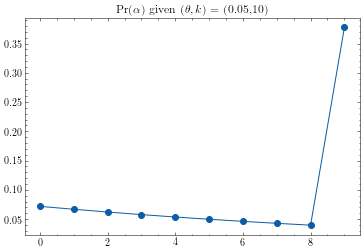

In [3]:
thetas = [0.05]
ks = [10]


for theta in thetas:
    for k in ks:
        profile_vector = profile_vec(theta,k)
        plt.plot(profile_vector,'o-')
        title = "(%s,%d)" % (theta,k)
        plt.title(r'$\Pr(\alpha)$ given $(\theta,k)$ = ' + title)
        

# Probability vector of f

We calculate in closed form for a variety of methods $\Pr(f)$ where $\Pr(f)$ is defined in the paper as the probabillity vector of a method. These closed forms can be found in the paper. 


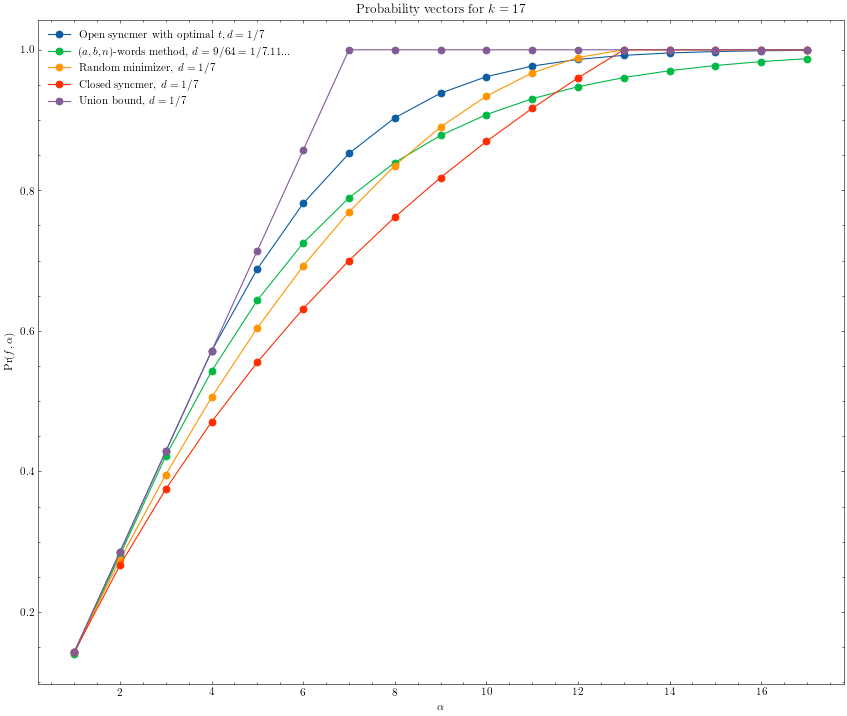

7.0 compression os
7.111111111111111 compression words
7.0 compression mini
7.0 compression closed sync


In [12]:
#There's a convention that a = \alpha - 1 is used in these functions, where alpha is the number
#of consecutive k-mers in the paper.

def falling_fac(a,b):
    term = 1
    for i in range(b,a):
        term *= (i+1)
    return term

#The prob. vector for the "abbb..." words scheme from Frith(2020).
#n : number of "b"s
#k : k-mer k
def words_prob(n,k):
    vec_prob = []
    for a in range(k):
        prob_sum = 0
        for i in range(1, a+2):
            prob_sum += (-1)**(i+1) * 3**(n*i)/(4 * 4**n)**i * binom((a+1) - n*(i-1),i)
        vec_prob.append(prob_sum)

    return(vec_prob)

#The prob. vector for the open-syncer with offset scheme from Edgar(2021).
#k : k-mer k
#s : s-mer s
#t : offset t
def union_os_prob_exact_middle(k,s,t):
    #L is the number of permutations which satisfy
    L_vec = [0,np.math.factorial(k-s)]
    prob_vec = [1/(k-s+1)]
    for i in range(2,k+1):
        alpha = k-s+i
        recur_term = 0
        last_term = 0
        for l in range(1,t):
            if i-l < 0:
                continue
            recur_term += L_vec[i-l] * np.math.factorial(alpha-1)/np.math.factorial(alpha-l)
            val = last_term / (L_vec[i-l] * np.math.factorial(alpha-1)/np.math.factorial(alpha-l) + 1)
            #if val != 0:
               # print(val)
            last_term = L_vec[i-l] * np.math.factorial(alpha-1)/np.math.factorial(alpha-l)
        for l in range(1,k-s-t+2):
            if i-l < 0:
                continue
            recur_term += L_vec[i-l] * np.math.factorial(alpha-1)/np.math.factorial(alpha-l)

        L_vec.append(i*np.math.factorial(alpha-1) + recur_term)
        prob_vec.append(L_vec[-1]/np.math.factorial(alpha))
    
    #print(prob_vec)
    #print(L_vec)
    return prob_vec

#closed syncmer 
def closed_sync(k,s):
    prob_vec = []
    for i in range(1,k+1):
        alpha = k - s + i
        prob = 2 * i * np.math.factorial(alpha - 1)/np.math.factorial(alpha)
        if prob > 1:
            prob_vec.append(1)
        else:
            prob_vec.append(prob)
    return prob_vec
    
#0 mod p scheme
def zero_mod_scheme_exact(p,k):
    return [1 - (1 - 1/p)**x for x in range(1,k+1)]

#random minimizer 
def minimizer_prob_exact(w,k):
    return_vec = []
    for a in range(0,w):
        ind = w
        M = np.zeros((2*w-1+a,2*w-1))

        #for p in range(1,(w+1)//2+1):
        for p in range(1,2*w):
            M[w-1,p-1] = (1+a)*np.math.factorial(w-1)
        for n in range(w+1,2*w+a):
            for p in range(1,2*w):
                M_term = (a+1)*np.math.factorial(n-1)
                l1 = p - 1
                r1 = n - (p + a)
                recur_term_2 = 0
                recur_term_1 = 0

                for i in range(1,l1+1):
                    recur_term_1 += M[n-i-1,l1 - i] * falling_fac(n-1,n-i)
                for i in range(1,r1+1):
                    #print(r1,l1,n,i,'r1 l1 n i',w,a)
                    recur_term_2 += M[n-i-1,r1 - i] * falling_fac(n-1,n-i)

                M[n-1,p-1] = M_term + recur_term_1 + recur_term_2

        np.set_printoptions(precision=2)
        return_vec.append(M[-1,w-1]/np.math.factorial(2*w-1+a))
    for i in range(k-w):
        return_vec.append(1.0)
    return return_vec

#Union bound on Pr(f)
def union_bound(k,p):
    ret_vec = []
    for i in range(k):
        if 1/p*(i+1) > 1:
            ret_vec.append(1)
        else:
            ret_vec.append((i+1)/p)
            
    return ret_vec

k = 17
w = 13
p = (w+1)//2
s = k-p + 1
cs_s = 2*s - k - 1
t = (k-s)//2 +1
n = 2

os_exact = union_os_prob_exact_middle(k,s,t)
zero_exact = zero_mod_scheme_exact(p,k)
words_exact = words_prob(n,k)
mini_exact = minimizer_prob_exact(w,k)
closed_sync_exact = closed_sync(k,cs_s)
ub = union_bound(k,p)

plt.figure(figsize=(13,11),dpi=80)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\Pr(f,\alpha)$')

plt.title(r'Probability vectors for $k = %s$'%(k))
plt.plot(range(1,k+1),os_exact,'-o',label = r'Open syncmer with optimal $t, d = 1/7$')
plt.plot(range(1,k+1),words_exact,'-o',label= r'$(a,b,n)$-words method, $d = 9/64 = 1/7.11...$')
plt.plot(range(1,k+1),mini_exact,'-o',label='Random minimizer, $d = 1/7$')
plt.plot(range(1,k+1),closed_sync_exact,'-o',label='Closed syncmer, $d = 1/7$')
plt.plot(range(1,k+1),ub,'-o',label='Union bound, $d = 1/7$')
plt.legend()
plt.show()


print(1/os_exact[0], "compression os")
print(1/words_exact[0], "compression words")
print(1/mini_exact[0],'compression mini')
print(1/closed_sync_exact[0],'compression closed sync')


# Comparing syncmer Pr(f) methods


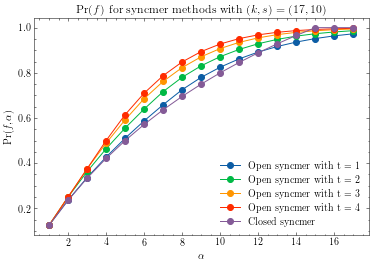

In [5]:
k = 17
s = 10
cs_s = 2*s - k - 1
ts = range(1,(k-s+2)//2+1)

for t in ts:
    os_vect = union_os_prob_exact_middle(k,s,t)
    label = r'Open syncmer with t = %s' %(t)
    plt.plot(range(1,k+1),os_vect,'-o',label = label)
cs_vect = closed_sync(k,cs_s)
plt.plot(range(1,k+1),cs_vect,'-o',label = 'Closed syncmer')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\Pr(f,\alpha)$')
plt.legend()
plt.title(r'$\Pr(f)$ for syncmer methods with $(k,s) = (%s,%s)$'%(k,s))
plt.show()

# Empirical probability distributions

We derived closed form expressions for how many permutations satisfy a certain property when computing $\Pr(f)$ for syncmers and minimizers. We can also empirically do so, and see how they match up with the theory.


0.1914 1
0.4016 2
0.5746 3
0.7228 4
0.8238 5
0.8986 6
0.9366 7
0.9692 8
0.983 9
0.9915 10
0.9949 11
0.9983 12
0.9987 13
0.9994 14
0.9998 15
0.9999 16
1.0 17


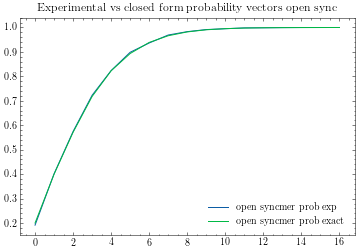

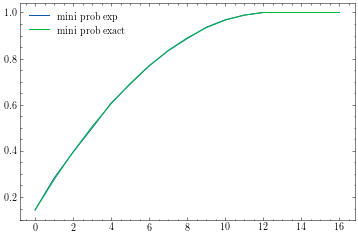

In [10]:
#Simulate with num_sims many permutations, check how
#many are successful for minimizers
def minimizer_prob_values(w,k, min_prob_values,num_sims):
    ##Problem in this simulation, wrong math
    for i in range (1,k+1):
        if i >= w:
            min_prob_values.append(1)
            continue
      #  print(i)
        num_suc = 0
        for j in range(num_sims):
            length_perm = 2*w - 2 + i 
            rand_perm = np.random.permutation(length_perm)
            for l in range(length_perm - w+1):
                left_inc_index = w-1
                right_inc_index = length_perm - w
                min_ind = np.argmin(rand_perm[l:l+w])
                if l + min_ind >= left_inc_index and l+min_ind <= right_inc_index:
        #            print(rand_perm[l:l+w],k,length_perm,w,rand_perm,left_inc_index,right_inc_index)
                    num_suc += 1
                    break

        #print(num_suc/num_sims,i)
        min_prob_values.append(num_suc/num_sims)
        
#Simulate random permutations, check how many are successful
def open_syncmer_prob_values_get(k,s,t,open_syncmer_prob_values,num_sims):
    for i in range(1,k+1):
        smers_in_1_kmer = k-s+1
        #number of s-mers in a "window" of valid k-mers
        num_smers = k - s + i
        num_suc = 0
        for j in range(num_sims):
            rand_perm = np.random.permutation(num_smers)
            #look at consecutive k-mers' s-mers to determine if they are chosen
            for l in range(num_smers - smers_in_1_kmer + 1):
                kmer_chunk = rand_perm[l : l+smers_in_1_kmer]
                if np.argmin(kmer_chunk) == t-1:
                    num_suc += 1
                    break
        print(num_suc/num_sims,i)
        open_syncmer_prob_values.append(num_suc/num_sims)

k = 17
s = 13
min_prob_values_exp = []
os_prob_values_exp = []
num_sims = 10000
os_exact = union_os_prob_exact_middle(k,s,t)
mini_exact = minimizer_prob_exact(w,k)

minimizer_prob_values(w,k,min_prob_values_exp,num_sims)
open_syncmer_prob_values_get(k,s,t,os_prob_values_exp,num_sims)

plt.plot(os_prob_values_exp,label = 'open syncmer prob exp')
plt.plot(os_exact,label = 'open syncmer prob exact')
plt.title("Experimental vs closed form probability vectors open sync")
plt.legend()
plt.show()

plt.plot(min_prob_values_exp,label='mini prob exp')
plt.plot(mini_exact,label='mini prob exact')
plt.legend()
plt.show()

#Empirical results from simulations

The results below are empirical results from simulations. They were obtained in rust and then copy and pasted over.

In [19]:
##Empirical results. Stored in emp_** text file, copy and pasted here. 
#for k = 24
os_cons_over_theta = [
    0.8971449400000001,
    0.7854196600000003,
    0.6730598399999999,
    0.5673365799999999,
    0.47264378000000007,
    0.3891510400000001,
    0.31717677999999994,
    0.25556848000000004,
    0.20518112,
    0.16312411999999996,
    0.12895374000000004,
    0.10144844000000001,
    0.07910765999999998,
    0.06188425999999997,
    0.04722440000000001,
]
cept_dens_mean = 0.12158664365227469
min_cons_over_theta = [
    0.8745431800000002,
    0.7478939399999998,
    0.6276925999999999,
    0.5190208199999999,
    0.42436008000000003,
    0.3438545400000001,
    0.2754275400000001,
    0.2188662799999999,
    0.17304701999999994,
    0.13553726,
    0.10580112,
    0.08198255999999997,
    0.06346327999999998,
    0.04886084,
    0.036885259999999996,
]
min_cons_std_over_theta = [
    0.0016590120729463663,
    0.002782092773144671,
    0.0031788741352366846,
    0.0034787952877600365,
    0.0034442501219606935,
    0.0029792927078063185,
    0.003524908146722162,
    0.0028333787521493334,
    0.0030343628555250103,
    0.0025997370442785066,
    0.002241825200116813,
    0.0019389040970026702,
    0.0018450604221033312,
    0.0015560501713497467,
    0.0015096093723111607,
]
cept_cons_over_theta = [
    0.8830978999999999,
    0.7625268800000002,
    0.6456358799999998,
    0.53839866,
    0.4440552000000001,
    0.36223104,
    0.2925774,
    0.23418798000000007,
    0.18646187999999994,
    0.14716978000000003,
    0.11541270000000005,
    0.09030569999999997,
    0.07006085999999999,
    0.05441830000000001,
    0.041392620000000005,
]
cept_cons_std_over_theta = [
    0.0015771310963104794,
    0.002597297170428354,
    0.0029795925939394134,
    0.0036435304008917333,
    0.003349775665638076,
    0.0032077670698075047,
    0.0034527425901650106,
    0.0031969674582155026,
    0.003056551166913389,
    0.0026960895122717676,
    0.002414328614038622,
    0.001992019682167175,
    0.0017796324953725305,
    0.0015554721748937484,
    0.0015225512267177744,
]
cust_cons_over_theta = [
    0.8986747000000003,
    0.78735836,
    0.6754631600000002,
    0.56987722,
    0.47472906000000015,
    0.3910401199999999,
    0.3186199800000001,
    0.25715703999999995,
    0.20618859999999994,
    0.16427853999999997,
    0.12966049999999998,
    0.10223598000000003,
    0.07950638000000002,
    0.06212232000000004,
    0.04761830000000001,
]
cust_cons_std_over_theta = [
    0.0014183829283071325,
    0.0024669596448448246,
    0.002936060566628194,
    0.0035990048219871696,
    0.0033228796013169805,
    0.0033283469227200152,
    0.0035784671453999786,
    0.0030683130426468488,
    0.0032063099089643904,
    0.0027543526597263107,
    0.0024921647622138062,
    0.0021110612295117057,
    0.0018764976337029922,
    0.0018211582000185898,
    0.0016942755521061638,
]

#####FOR k = 17
# min_cons_over_theta = [
#     0.9351530799999997,
#     0.86070734,
#     0.7818773400000003,
#     0.7024086599999998,
#     0.6246628400000003,
#     0.55179364,
#     0.48315958000000014,
#     0.4202000800000001,
#     0.36298619999999987,
#     0.3119942600000001,
#     0.26683363999999987,
#     0.22765424000000004,
#     0.19261272000000002,
#     0.16263298000000004,
#     0.13650622,
# ]
# min_cons_std_over_theta = [
#     0.001270263296336717,
#     0.0018267205932097495,
#     0.001997872485693443,
#     0.00248216619398167,
#     0.0032691380284241454,
#     0.0028279783317501704,
#     0.0029830012450347363,
#     0.0025587167225510957,
#     0.002449086220028059,
#     0.0027815798672660434,
#     0.0026538377376504737,
#     0.002799842553726291,
#     0.0026134604564009988,
#     0.002125431055412791,
#     0.0017600775211348038,
# ]
# cept_cons_over_theta = [
#     0.9411559600000002,
#     0.8713427600000001,
#     0.7960538800000004,
#     0.7193780799999999,
#     0.64281028,
#     0.5707193599999999,
#     0.5023523000000001,
#     0.4388876199999999,
#     0.3811791400000001,
#     0.32915431999999994,
#     0.28268663999999993,
#     0.24216526,
#     0.20607611999999992,
#     0.17472378000000005,
#     0.14721923999999997,
# ]
# cept_cons_std_over_theta = [
#     0.0012636029289378086,
#     0.0017255012980861447,
#     0.0021727659571722114,
#     0.002550043880311705,
#     0.0029438701939433188,
#     0.002793582514090165,
#     0.0030247466527184266,
#     0.002576022440064755,
#     0.0027294402468290247,
#     0.0027954238032899393,
#     0.002623968632480659,
#     0.002872304430208954,
#     0.002541313679532257,
#     0.0020751530725089742,
#     0.0018867802467150067,
# ]
# cust_cons_over_theta = [
#     0.9480295799999999,
#     0.8833947200000002,
#     0.8117304399999999,
#     0.7374000399999998,
#     0.6624233400000005,
#     0.5910150000000001,
#     0.5223999,
#     0.4585824000000001,
#     0.4000405399999999,
#     0.34667760000000003,
#     0.2991202799999999,
#     0.25714318000000014,
#     0.21958635999999998,
#     0.18677548,
#     0.15786988,
# ]
#  cust_cons_std_over_theta = [
#      0.0010788729358535097,
#      0.0016856883621065323,
#      0.0020600728746548976,
#      0.0023142893139551242,
#      0.0029431049096991053,
#      0.0026886823253156294,
#      0.002976520853939945,
#      0.0025428887255849533,
#      0.002755639284643529,
#      0.00300926175718104,
#      0.002810749869678728,
#      0.002853391419615498,
#      0.0027389436492077286,
#      0.002171057920587438,
#      0.0019769766289754547,
#  ]


# min_cons_over_theta = [
#     0.9351359000000002,
#     0.8606015600000001,
#     0.7816619599999999,
#     0.7024554000000001,
#     0.62427886,
#     0.5512015600000002,
# #     0.48300004000000024,
#     0.42051283999999994,
#     0.36362122000000013,
#     0.3127760399999999,
#     0.26713556000000016,
#     0.2268757199999999,
#     0.19233765999999997,
#     0.16239798,
#     0.13655928,
# ]
# min_cons_std_over_theta = [
#     0.0011671498350142254,
#     0.0016458999706954682,
#     0.002121272059378283,
#     0.002660897934566791,
#     0.002385889872825763,
#     0.0028922194138373625,
#     0.0029851418317995517,
#     0.002964066142202893,
#     0.0029455655682343374,
#     0.0032413124786484903,
#     0.0028018922261337413,
#     0.0026724213667032606,
#     0.00228244078206563,
#     0.00211839263431766,
#     0.0021196189770043023,
# ]
# cept_cons_over_theta = [
#     0.9410992600000003,
#     0.8713851799999999,
#     0.7960512999999999,
#     0.7189305400000001,
#     0.6425407800000003,
#     0.5701089999999999,
#     0.50218264,
#     0.43926603999999986,
#     0.3818137799999998,
#     0.32996976000000006,
#     0.28323216,
#     0.24145072000000012,
#     0.20562588000000004,
#     0.17431507999999993,
#     0.14713476,
# ]
# cept_cons_std_over_theta = [
#     0.0010633598611680954,
#     0.0015265422231932886,
#     0.002131008020120569,
#     0.002466207309480148,
#     0.0025543108010347626,
#     0.002937671000825466,
#     0.002965352311907876,
#     0.003014924532683658,
#     0.002949220693435109,
#     0.0030125844642000356,
#     0.002907188981150211,
#     0.002656036821577547,
#     0.002485144612096105,
#     0.0021921094756264586,
#     0.002255184281569554,
# ]
# cust_cons_over_theta = [
#     0.9462330799999998,
#     0.8802564599999999,
#     0.8077687599999998,
#     0.73276752,
#     0.6574556199999998,
#     0.5856164600000002,
#     0.51758772,
#     0.4544621200000001,
#     0.3963587800000002,
#     0.34353032,
#     0.29596758000000006,
#     0.2532277399999999,
#     0.21631384,
#     0.18408911999999997,
#     0.15573469999999998,
# ]
# cust_cons_std_over_theta = [
#     0.0010147231864161281,
#     0.0014410424637123717,
#     0.0019209992303039236,
#     0.0025836760456154025,
#     0.0026042622204239087,
#     0.0030226629085939884,
#     0.0030071411440439587,
#     0.003071587012170311,
#     0.00299374361627712,
#     0.003150936737036793,
#     0.00285675264245997,
#     0.0026242591436306906,
#     0.0024345288666237325,
#     0.002297988040865224,
#     0.0022848874494306405,
# ]



# Calculations of $\text{Cons}(f,t,\theta)$.



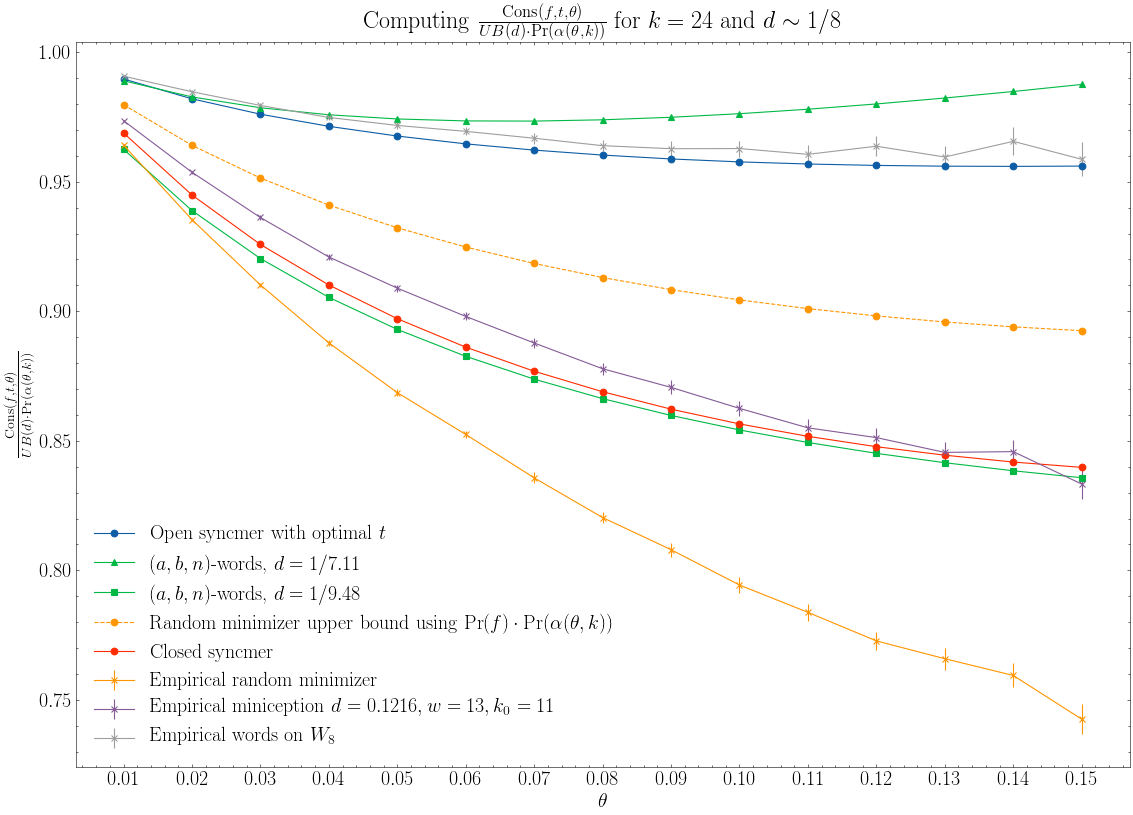

In [18]:
#Parameters for figure with k = 17 and comparing Pr(f) in the paper
#k = 17
#w = 13
#p = (w+1)//2
#s = k-p+1
#cs_s = 2*s - k - 1
#t = (k-s)//2 +1
#n = 2

#Parameters for k = 24 and comparing conservation in the paper
k = 24
w = 15
p = (w+1)//2
s = k-p + 1
cs_s = 2*s - k - 1
t = (k-s)//2 +1
n = 2
samp_size =100 

thetas = np.linspace(0.01,0.15,15);
mini_cons = []
os_cons = []
os_cons_emp = []
words_cons = []
words3_cons = []
ub_cons = []
cs_cons = []
mini_cons_emp = []
mini_cons_emp_er = []
cept_cons_emp = []
cept_cons_emp_er = []
cust_cons_emp = []
cust_cons_emp_er = []

os_exact = union_os_prob_exact_middle(k,s,t)
words_exact = words_prob(n,k)
words3_exact = words_prob(n+1,k)
mini_exact = minimizer_prob_exact(w,k)
cs_exact = closed_sync(k,cs_s)
ub = union_bound(k,p)

plt.figure(figsize=(17,12),dpi=80)
plt.rcParams.update({'font.size': 18})

for (i,theta) in enumerate(thetas):
    profile_vector = profile_vec(theta,k)
    ub_cons.append(np.dot(ub,profile_vector))
    mini_cons.append(np.dot(mini_exact,profile_vector)/ub_cons[-1])
    os_cons.append(np.dot(os_exact,profile_vector)/ub_cons[-1])
    cs_cons.append(np.dot(cs_exact,profile_vector)/ub_cons[-1])
    words_cons.append(np.dot(words_exact,profile_vector)/ub_cons[-1])
    words3_cons.append(np.dot(words3_exact,profile_vector)/ub_cons[-1])
    mini_cons_emp.append(min_cons_over_theta[i]/ub_cons[-1])
    mini_cons_emp_er.append(min_cons_std_over_theta[i]/ub_cons[-1])
    cept_cons_emp.append(cept_cons_over_theta[i]/ub_cons[-1])
    cept_cons_emp_er.append(cept_cons_std_over_theta[i]/ub_cons[-1])
    cust_cons_emp.append(cust_cons_over_theta[i]/ub_cons[-1])
    cust_cons_emp_er.append(cust_cons_std_over_theta[i]/ub_cons[-1])

#1.92 from t-distribution for n = 100
mini_cons_emp_er = np.array(mini_cons_emp_er) * 1.92 / np.sqrt(samp_size);
cept_cons_emp_er = np.array(cept_cons_emp_er) * 1.92 / np.sqrt(samp_size);
cust_cons_emp_er = np.array(cust_cons_emp_er) * 1.92 / np.sqrt(samp_size);

plt.plot(thetas,os_cons,'-o',label='Open syncmer with optimal $t$')
plt.plot(thetas,words_cons,'-^',label='$(a,b,n)$-words, $d = 1/7.11$')
plt.plot(thetas,words3_cons,'-s',c='C1',label='$(a,b,n)$-words, $d = 1/9.48$')
plt.plot(thetas,mini_cons,'--o',c='C2',label=r'Random minimizer upper bound using $\Pr(f) \cdot \Pr(\alpha(\theta,k))$')
plt.plot(thetas,cs_cons,'-o',c='C3',label='Closed syncmer')
plt.errorbar(thetas,mini_cons_emp,fmt='-x',c='C2',yerr=mini_cons_emp_er,label=r'Empirical random minimizer')
plt.errorbar(thetas,cept_cons_emp,fmt='-x',c='C4',yerr=cept_cons_emp_er,label=r'Empirical miniception $d = 0.1216, w = 13, k_0 = 11$')
plt.errorbar(thetas,cust_cons_emp,fmt='-x',c='C6',yerr=cust_cons_emp_er,label=r'Empirical words on $W_8$')
plt.xticks(thetas)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\frac{\text{Cons}(f,t,\theta)}{UB(d) \cdot \Pr(\alpha(\theta,k))}$')
plt.title(r'Computing $\frac{\text{Cons}(f,t,\theta)}{UB(d) \cdot \Pr(\alpha(\theta,k))}$ for $k = 24$ and $d \sim 1/8$')
#plt.plot(ub_cons,label='ub cons')
plt.legend()
plt.show()
